In [2]:
# !pip install scikit-image

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-09-12 12:53:52.833668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 12:53:52.842825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 12:53:52.853453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 12:53:52.856356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 12:53:52.864528: I tensorflow/core/platform/cpu_feature_guar

# Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [5]:
image = load_img("./catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

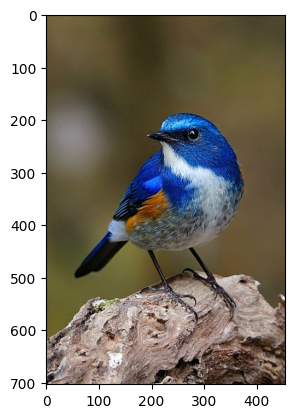

In [6]:
plt.imshow(image)
plt.show()

In [7]:
datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [8]:
image_array.reshape((1,) + image_array.shape).shape

(1, 703, 454, 3)

In [9]:
image_array.shape

(703, 454, 3)

In [10]:
image_array = image_array.reshape((1,) + image_array.shape)

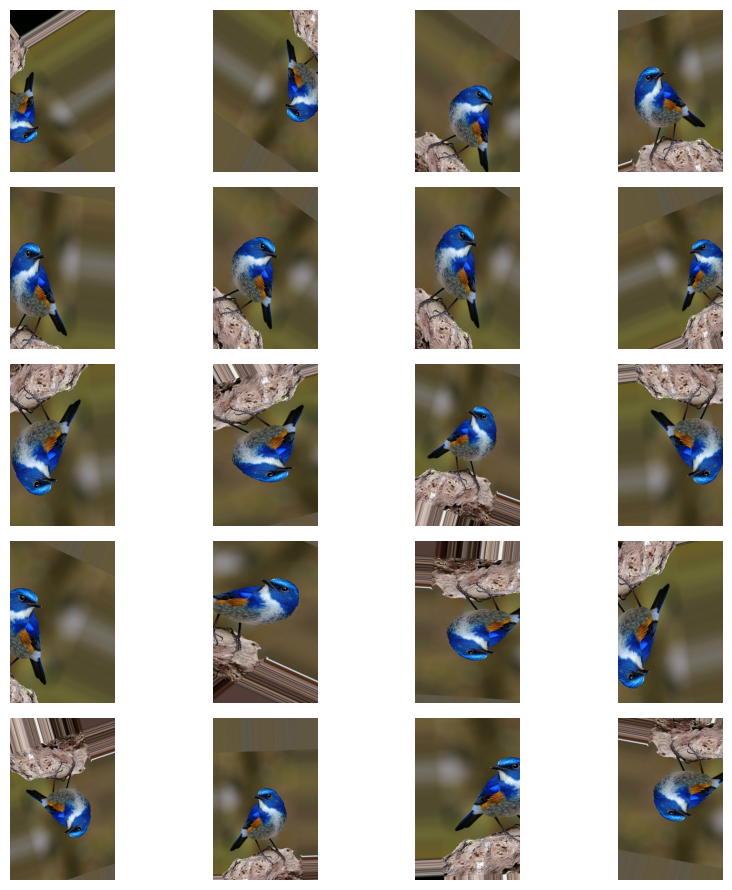

In [11]:
fig, axes = plt.subplots(5, 4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    if i >= 20:   # 20개 이미지 생성 후 종료
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 전이학습 
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 훈련하거나 결과를 출력

In [12]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2, 
import tensorflow as tf

# GPU 디바이스 설정
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

I0000 00:00:1726145635.456618    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.460512    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.460545    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [13]:
base_model = ResNet50(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

I0000 00:00:1726145635.470968    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.471038    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.471056    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.569317    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726145635.569372    1844 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-12

In [14]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Dense(2, activation='sigmoid'))
# model.summary()

In [16]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet50_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [17]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [18]:
train = ImageDataGenerator(
            rescale=1.0/255,
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.2,
            shear_range=0.6,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

train_gen = train.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [19]:
valid = ImageDataGenerator(rescale=1.0/255)
valid_gen = valid.flow_from_directory(train_dir, target_size=(image_height, image_width),
                                     color_mode='rgb',
                                     batch_size=batch_size,
                                     seed=7,
                                     shuffle=True,
                                     class_mode='categorical')

Found 385 images belonging to 2 classes.


In [20]:
history=model.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726145646.678088    1944 service.cc:146] XLA service 0x7f35e8062840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726145646.678131    1944 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-12 12:54:06.770785: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 12:54:07.372150: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-12 12:5

1/2 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/step - accuracy: 0.4600 - loss: 0.6935

2024-09-12 12:54:20.522431: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 4 bytes spill stores, 4 bytes spill loads

2024-09-12 12:54:20.895751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 64 bytes spill stores, 64 bytes spill loads

2024-09-12 12:54:20.958234: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 184 bytes spill stores, 184 bytes spill loads

2024-09-12 12:54:21.123295: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5666', 548 bytes spill stores, 376 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 22s/step - accuracy: 0.4685 - loss: 0.6934 - val_accuracy: 0.4727 - val_loss: 0.6932
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.4685 - loss: 0.6933 - val_accuracy: 0.4909 - val_loss: 0.6931
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.4789 - loss: 0.6931 - val_accuracy: 0.5273 - val_loss: 0.6931
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6930 - val_accuracy: 0.5273 - val_loss: 0.6930
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 8s/step - accuracy: 0.5353 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6929
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5298 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6928
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5482 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6927
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.5182 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6927
Epoch

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5281 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 53/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5245 - loss: 0.6919 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 54/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.5382 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 55/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6918 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 56/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 57/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5137 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 58/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5448 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6916
Epoch 59/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5191 - loss: 0.6924 - val_accuracy: 0.5273 - val_loss: 0.691

Epoch 103/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5415 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 104/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5155 - loss: 0.6927 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 105/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6912 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 106/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5317 - loss: 0.6910 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 107/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5215 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 108/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5348 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 109/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5191 - loss: 0.6923 - val_accuracy: 0.5273 - val_loss: 0.6914
Epoch 110/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6925 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5245 - loss: 0.6917 - val_accuracy: 0.5273 - val_loss: 0.6913
Epoch 154/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5263 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6913
Epoch 155/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5115 - loss: 0.6931 - val_accuracy: 0.5273 - val_loss: 0.6913
Epoch 156/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5227 - loss: 0.6918 - val_accuracy: 0.5273 - val_loss: 0.6913
Epoch 157/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5299 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss: 0.6913
Epoch 158/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5389 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6913
Epoch 159/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5248 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss: 0.6912
Epoch 160/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5335 - loss: 0.6906 - val_accuracy: 0.5273 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5298 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 204/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5335 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 205/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5155 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 206/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5245 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 207/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5173 - loss: 0.6924 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 208/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5137 - loss: 0.6927 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 209/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6911
Epoch 210/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5209 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5245 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 254/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5198 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 255/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5353 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 256/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5265 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 257/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5371 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 258/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6924 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 259/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5198 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6910
Epoch 260/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5389 - loss: 0.6898 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5382 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 304/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5407 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 305/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5317 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 306/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5232 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 307/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5137 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 308/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5282 - loss: 0.6910 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 309/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5332 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6908
Epoch 310/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step - accuracy: 0.5209 - loss: 0.6918 - val_accuracy: 0.5273 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5209 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 354/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5115 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 355/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5317 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 356/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 357/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5298 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 358/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5132 - loss: 0.6926 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 359/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6907
Epoch 360/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.5245 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5232 - loss: 0.6912 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 404/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5165 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 405/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5335 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 406/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5209 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 407/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 408/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5335 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 409/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5119 - loss: 0.6928 - val_accuracy: 0.5273 - val_loss: 0.6905
Epoch 410/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5198 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5232 - loss: 0.6909 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 454/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5432 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 455/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5332 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 456/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.5232 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 457/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 8s/step - accuracy: 0.5461 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 458/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5209 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 459/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5282 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6904
Epoch 460/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 12s/step - accuracy: 0.5265 - loss: 0.6909 - val_accuracy: 0.5273 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5148 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 504/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5332 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 505/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5389 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 506/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 507/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 508/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5048 - loss: 0.6930 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 509/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5282 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6902
Epoch 510/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5232 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5281 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 554/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5173 - loss: 0.6916 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 555/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5332 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 556/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5101 - loss: 0.6923 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 557/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 558/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5227 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 559/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5191 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6901
Epoch 560/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5065 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5148 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 604/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5407 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 605/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5348 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 606/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 607/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5132 - loss: 0.6921 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 608/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 609/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5263 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6899
Epoch 610/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5263 - loss: 0.6909 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5353 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 654/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5232 - loss: 0.6909 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 655/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5365 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 656/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 657/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5298 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 658/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5165 - loss: 0.6912 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 659/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5353 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6898
Epoch 660/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5265 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5119 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 704/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5398 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 705/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5389 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 706/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5227 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 707/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5299 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 708/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5227 - loss: 0.6909 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 709/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5398 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6896
Epoch 710/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6901 - val_accuracy: 0.5273 - val_lo

2024-09-12 15:20:00.390640: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5311 - loss: 0.6894

2024-09-12 15:20:02.369775: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.5298 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 743/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 14s/step - accuracy: 0.5155 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 744/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5298 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 745/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5353 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 746/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 747/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5263 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 748/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5198 - loss: 0.6913 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 749/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 26s/step - accuracy: 0.5407 - loss: 0.6885 - val_accuracy: 0.5273 - va

2024-09-12 15:26:53.765886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 111392200 bytes after encountering the first element of size 111392200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5371 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 770/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5248 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6895
Epoch 771/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5298 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 772/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 10s/step - accuracy: 0.5245 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 773/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5182 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 774/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 775/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5282 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6894
Epoch 776/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5215 - loss: 0.6908 - val_accuracy: 0.5273 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5335 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 820/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5371 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 821/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5198 - loss: 0.6915 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 822/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5298 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 823/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5137 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 824/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5182 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 825/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5365 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6893
Epoch 826/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5265 - loss: 0.6911 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5115 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 870/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5365 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 871/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5281 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 872/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5215 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 873/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5191 - loss: 0.6914 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 874/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5215 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6892
Epoch 875/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5165 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6891
Epoch 876/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5382 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5299 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 920/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5398 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 921/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5182 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 922/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5165 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 923/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 924/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5215 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 925/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5263 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6890
Epoch 926/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5371 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 970/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5332 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 971/2000


2024-09-12 16:08:29.207166: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5336 - loss: 0.6890

2024-09-12 16:08:31.199497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 972/2000


2024-09-12 16:08:41.847413: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.5186 - loss: 0.6898

2024-09-12 16:08:43.724508: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5215 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 973/2000


2024-09-12 16:08:54.110142: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 111392200 bytes after encountering the first element of size 111392200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5366 - loss: 0.6883

2024-09-12 16:08:56.012198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5335 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 974/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5248 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 975/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 976/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5332 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 977/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5263 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 978/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5365 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6889
Epoch 979/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5415 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 980/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5382 - loss: 0.6884 - val_accuracy: 0.5273 - val_loss

2024-09-12 16:14:34.011444: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5248 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1002/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5299 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1003/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5365 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1004/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5282 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1005/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5065 - loss: 0.6919 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1006/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5365 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1007/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5245 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1008/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5479 - loss: 0.6877 - val_accuracy: 0.5273 - v

2024-09-12 16:16:53.223133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.5211 - loss: 0.6902

2024-09-12 16:16:55.018700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5232 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6888
Epoch 1013/2000


2024-09-12 16:17:05.686905: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 120424000 bytes after encountering the first element of size 120424000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1014/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5353 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1015/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5443 - loss: 0.6877 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1016/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5155 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1017/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5353 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1018/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5248 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1019/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5065 - loss: 0.6920 - val_accuracy: 0.5273 - val_loss: 0.6887
Epoch 1020/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6898 - val_accuracy: 0.5273 - v

2024-09-12 16:25:53.179443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:25:53.180747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 33s/step - accuracy: 0.5132 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1052/2000


2024-09-12 16:26:37.793340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:26:37.795023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 20s/step - accuracy: 0.5432 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1053/2000


2024-09-12 16:27:09.844390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:27:09.845410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 35s/step - accuracy: 0.5382 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1054/2000


2024-09-12 16:27:56.855899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:27:56.857080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 48s 36s/step - accuracy: 0.5198 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1055/2000


2024-09-12 16:28:46.482299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:28:46.483645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 31s/step - accuracy: 0.5298 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1056/2000


2024-09-12 16:29:30.553224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:29:30.554974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 31s/step - accuracy: 0.5215 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1057/2000


2024-09-12 16:30:15.345869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:30:15.347263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 29s/step - accuracy: 0.5415 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1058/2000


2024-09-12 16:30:55.523078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:30:55.524496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 27s/step - accuracy: 0.5198 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1059/2000


2024-09-12 16:31:36.867477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:31:36.869095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 63s 49s/step - accuracy: 0.5315 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1060/2000


2024-09-12 16:32:41.793703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:32:41.794882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 29s/step - accuracy: 0.5389 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1061/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 8s/step - accuracy: 0.5198 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1062/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5281 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1063/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5248 - loss: 0.6896 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1064/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5191 - loss: 0.6908 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1065/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5265 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1066/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5348 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1067/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5299 - loss: 0.6890 - val_accuracy: 0.5273 - 

2024-09-12 16:38:37.610822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:38:37.612289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.5265 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6886
Epoch 1081/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 9s/step - accuracy: 0.5407 - loss: 0.6878 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1082/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5332 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1083/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5335 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1084/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5415 - loss: 0.6884 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1085/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.5165 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1086/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 11s/step - accuracy: 0.5245 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1087/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 17s/step - accuracy: 0.5232 - loss: 0.6902 - val_accuracy: 0.5273 -

2024-09-12 16:40:40.927415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:40:40.928888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 65s 50s/step - accuracy: 0.5317 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1089/2000


2024-09-12 16:41:48.668711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:41:48.669623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.5448 - loss: 0.6880 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1090/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5398 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1091/2000


2024-09-12 16:42:18.664832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:42:18.666311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 41s/step - accuracy: 0.5332 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1092/2000


2024-09-12 16:43:18.311537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:43:18.312646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 51s/step - accuracy: 0.5232 - loss: 0.6898 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1093/2000


2024-09-12 16:44:20.153662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8
2024-09-12 16:44:22.811827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 32s/step - accuracy: 0.5335 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1094/2000


2024-09-12 16:45:07.005378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:45:07.007009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 57s 45s/step - accuracy: 0.5265 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1095/2000


2024-09-12 16:46:06.206700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 16:46:06.208196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 31s/step - accuracy: 0.5317 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1096/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5232 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1097/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5335 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1098/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1099/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5191 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1100/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5173 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1101/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6885
Epoch 1102/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5137 - loss: 0.6910 - val_accuracy: 0.5273 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5148 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1146/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1147/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1148/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5448 - loss: 0.6875 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1149/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5215 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1150/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1151/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6884
Epoch 1152/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5232 - loss: 0.6895 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5132 - loss: 0.6906 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1196/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5148 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1197/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5263 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1198/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5245 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1199/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5245 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1200/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5443 - loss: 0.6869 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1201/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6882
Epoch 1202/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5265 - loss: 0.6896 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5232 - loss: 0.6895 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1246/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5165 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1247/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5282 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1248/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5348 - loss: 0.6880 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1249/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5137 - loss: 0.6907 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1250/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5198 - loss: 0.6898 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1251/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6881
Epoch 1252/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5371 - loss: 0.6878 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5263 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1296/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5352 - loss: 0.6874 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1297/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5232 - loss: 0.6892 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1298/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5227 - loss: 0.6899 - val_accuracy: 0.5273 - val_loss: 0.6880
Epoch 1299/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5173 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6879
Epoch 1300/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5298 - loss: 0.6888 - val_accuracy: 0.5273 - val_loss: 0.6879
Epoch 1301/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5407 - loss: 0.6874 - val_accuracy: 0.5273 - val_loss: 0.6879
Epoch 1302/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5335 - loss: 0.6886 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5335 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1346/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5148 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1347/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5248 - loss: 0.6888 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1348/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5353 - loss: 0.6877 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1349/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5191 - loss: 0.6900 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1350/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5443 - loss: 0.6868 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1351/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6890 - val_accuracy: 0.5273 - val_loss: 0.6878
Epoch 1352/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5245 - loss: 0.6892 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1396/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5317 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1397/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5148 - loss: 0.6897 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1398/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5371 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1399/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5365 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1400/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5227 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1401/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5248 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6877
Epoch 1402/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5415 - loss: 0.6872 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5298 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6876
Epoch 1446/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 9s/step - accuracy: 0.5265 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6875
Epoch 1447/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5353 - loss: 0.6883 - val_accuracy: 0.5273 - val_loss: 0.6875
Epoch 1448/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5425 - loss: 0.6872 - val_accuracy: 0.5273 - val_loss: 0.6875
Epoch 1449/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5208 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6875
Epoch 1450/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5335 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6875
Epoch 1451/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6875
Epoch 1452/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5227 - loss: 0.6889 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.5298 - loss: 0.6881 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1496/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1497/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5226 - loss: 0.6905 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1498/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5227 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1499/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6902 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1500/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5382 - loss: 0.6873 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1501/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5281 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6874
Epoch 1502/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6887 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5165 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1546/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5298 - loss: 0.6881 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1547/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1548/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5352 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1549/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5416 - loss: 0.6872 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1550/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5335 - loss: 0.6874 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1551/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5352 - loss: 0.6877 - val_accuracy: 0.5273 - val_loss: 0.6873
Epoch 1552/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6888 - val_accuracy: 0.5273 - v

2024-09-12 18:20:12.733343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 18:20:12.734789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.5208 - loss: 0.6887 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1561/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5132 - loss: 0.6903 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1562/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5173 - loss: 0.6901 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1563/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5245 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1564/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6894 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1565/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5315 - loss: 0.6879 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1566/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5182 - loss: 0.6904 - val_accuracy: 0.5273 - val_loss: 0.6872
Epoch 1567/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5191 - loss: 0.6904 - val_accuracy: 0.5273 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5370 - loss: 0.6880 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1611/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5298 - loss: 0.6885 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1612/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5280 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1613/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5182 - loss: 0.6891 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1614/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5263 - loss: 0.6889 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1615/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 10s/step - accuracy: 0.5280 - loss: 0.6884 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1616/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5298 - loss: 0.6880 - val_accuracy: 0.5273 - val_loss: 0.6871
Epoch 1617/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5349 - loss: 0.6877 - val_accuracy: 0.5273 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5389 - loss: 0.6870 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1661/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5317 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1662/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5315 - loss: 0.6882 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1663/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5226 - loss: 0.6893 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1664/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5173 - loss: 0.6888 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1665/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5416 - loss: 0.6872 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1666/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5244 - loss: 0.6886 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 1667/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5173 - loss: 0.6896 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5148 - loss: 0.6899 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1711/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5299 - loss: 0.6885 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1712/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5190 - loss: 0.6895 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1713/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6887 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1714/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5352 - loss: 0.6880 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1715/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5182 - loss: 0.6900 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1716/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5425 - loss: 0.6870 - val_accuracy: 0.5299 - val_loss: 0.6868
Epoch 1717/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5370 - loss: 0.6870 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5382 - loss: 0.6875 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1761/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5298 - loss: 0.6882 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1762/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5280 - loss: 0.6886 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1763/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5232 - loss: 0.6884 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1764/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5245 - loss: 0.6889 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1765/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5352 - loss: 0.6868 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1766/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5442 - loss: 0.6867 - val_accuracy: 0.5299 - val_loss: 0.6867
Epoch 1767/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5165 - loss: 0.6899 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5209 - loss: 0.6877 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1811/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5227 - loss: 0.6891 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1812/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6871 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1813/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6875 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1814/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5449 - loss: 0.6863 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1815/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5248 - loss: 0.6890 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1816/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5226 - loss: 0.6884 - val_accuracy: 0.5299 - val_loss: 0.6866
Epoch 1817/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5265 - loss: 0.6876 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5262 - loss: 0.6889 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1861/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5399 - loss: 0.6872 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1862/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5245 - loss: 0.6887 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1863/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5209 - loss: 0.6894 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1864/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5299 - loss: 0.6866 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1865/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5265 - loss: 0.6885 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1866/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5137 - loss: 0.6894 - val_accuracy: 0.5299 - val_loss: 0.6865
Epoch 1867/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5264 - loss: 0.6885 - val_accuracy: 0.5299 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5136 - loss: 0.6894 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1911/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5266 - loss: 0.6886 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1912/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5370 - loss: 0.6876 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1913/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5407 - loss: 0.6866 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1914/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5443 - loss: 0.6870 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1915/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.5317 - loss: 0.6876 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1916/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5266 - loss: 0.6877 - val_accuracy: 0.5299 - val_loss: 0.6863
Epoch 1917/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5365 - loss: 0.6866 - val_accuracy: 0.5299 - va

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5317 - loss: 0.6871 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1961/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5352 - loss: 0.6881 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1962/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5316 - loss: 0.6876 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1963/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5315 - loss: 0.6871 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1964/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5244 - loss: 0.6888 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1965/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.5299 - loss: 0.6879 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1966/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.5334 - loss: 0.6878 - val_accuracy: 0.5299 - val_loss: 0.6862
Epoch 1967/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.5282 - loss: 0.6878 - val_accuracy: 0.5299 - v

# Resnet

In [21]:
base_model2 = ResNet152V2(include_top=True,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=None,
                        pooling=None,
                        classes=1000)

242745792/242745792 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [22]:
base_model2.summary()

Model: "resnet152v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 60,380,648 (230.33 MB)

 Trainable params: 60,236,904 (229.79 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [23]:
base_model2.trainable = False
model2 = Sequential()
model2.add(base_model2)
model2.add(Dense(2, activation='sigmoid'))
# model.summary()

In [24]:
model2.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
modelpath = "./model/Resnet152V2_catndog.keras"
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True)
earlystop = EarlyStopping(patience=100)

In [25]:
train_dir = "./catanddog/train/"
valid_dir = "./catanddog/validation/"
batch_size= 200
image_height = 224
image_width = 224

In [ ]:
history2=model2.fit(train_gen, epochs=2000, validation_data=valid_gen, callbacks=[earlystop, checkpoint])

Epoch 1/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 38s/step - accuracy: 0.5604 - loss: 0.6918 - val_accuracy: 0.5740 - val_loss: 0.6907
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.5461 - loss: 0.6912 - val_accuracy: 0.5870 - val_loss: 0.6899
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 12s/step - accuracy: 0.5663 - loss: 0.6905 - val_accuracy: 0.6234 - val_loss: 0.6891
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.5841 - loss: 0.6906 - val_accuracy: 0.6312 - val_loss: 0.6883
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.5999 - loss: 0.6896 - val_accuracy: 0.6545 - val_loss: 0.6875
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.6498 - loss: 0.6893 - val_accuracy: 0.6779 - val_loss: 0.6867
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.6718 - loss: 0.6881 - val_accuracy: 0.6831 - val_loss: 0.6859
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 14s/step - accuracy: 0.6457 - loss: 0.6878 - val_accuracy: 0.6961 - v

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.7878 - loss: 0.6631 - val_accuracy: 0.8831 - val_loss: 0.6526
Epoch 52/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.8124 - loss: 0.6617 - val_accuracy: 0.8831 - val_loss: 0.6519
Epoch 53/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.7661 - loss: 0.6624 - val_accuracy: 0.8831 - val_loss: 0.6512
Epoch 54/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.7710 - loss: 0.6631 - val_accuracy: 0.8909 - val_loss: 0.6505
Epoch 55/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.7841 - loss: 0.6635 - val_accuracy: 0.8909 - val_loss: 0.6498
Epoch 56/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.8281 - loss: 0.6591 - val_accuracy: 0.8909 - val_loss: 0.6490
Epoch 57/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 15s/step - accuracy: 0.7999 - loss: 0.6602 - val_accuracy: 0.8909 - val_loss: 0.6483
Epoch 58/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 12s/step - accuracy: 0.7934 - loss: 0.6577 - val_accuracy: 0.8909 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 14s/step - accuracy: 0.8105 - loss: 0.6390 - val_accuracy: 0.9273 - val_loss: 0.6179
Epoch 102/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 12s/step - accuracy: 0.8376 - loss: 0.6383 - val_accuracy: 0.9273 - val_loss: 0.6173
Epoch 103/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 14s/step - accuracy: 0.8190 - loss: 0.6359 - val_accuracy: 0.9273 - val_loss: 0.6166
Epoch 104/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.8308 - loss: 0.6370 - val_accuracy: 0.9273 - val_loss: 0.6159
Epoch 105/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.8393 - loss: 0.6370 - val_accuracy: 0.9273 - val_loss: 0.6153
Epoch 106/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.8273 - loss: 0.6368 - val_accuracy: 0.9273 - val_loss: 0.6146
Epoch 107/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 12s/step - accuracy: 0.8256 - loss: 0.6358 - val_accuracy: 0.9273 - val_loss: 0.6140
Epoch 108/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.8191 - loss: 0.6368 - val_accuracy: 0.9299 - 

2024-09-12 20:29:06.752999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4011: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 20:29:06.755304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 53s/step - accuracy: 0.8359 - loss: 0.6206 - val_accuracy: 0.9351 - val_loss: 0.5952
Epoch 137/2000


2024-09-12 20:30:12.401812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4011: Filling up shuffle buffer (this may take a while): 2 of 8
2024-09-12 20:30:12.403676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 117s 104s/step - accuracy: 0.8700 - loss: 0.6172 - val_accuracy: 0.9351 - val_loss: 0.5946
Epoch 138/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.8614 - loss: 0.6172 - val_accuracy: 0.9351 - val_loss: 0.5939
Epoch 139/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 16s/step - accuracy: 0.8238 - loss: 0.6206 - val_accuracy: 0.9377 - val_loss: 0.5933
Epoch 140/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 13s/step - accuracy: 0.8739 - loss: 0.6155 - val_accuracy: 0.9377 - val_loss: 0.5926
Epoch 141/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 13s/step - accuracy: 0.8188 - loss: 0.6207 - val_accuracy: 0.9377 - val_loss: 0.5920
Epoch 142/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 15s/step - accuracy: 0.8187 - loss: 0.6201 - val_accuracy: 0.9377 - val_loss: 0.5914
Epoch 143/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 12s/step - accuracy: 0.8492 - loss: 0.6178 - val_accuracy: 0.9403 - val_loss: 0.5908
Epoch 144/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.8298 - loss: 0.6171 - val_accuracy: 0.9403 